### Step 1: Load and Explore the Dataset

I'll begin by loading the dataset into a pandas DataFrame and taking a quick look at the first few rows.


In [4]:
import pandas as pd

# Load the dataset
airlines_reviews_df = pd.read_csv('airlines_reviews.csv')

# Display the first few rows of the dataset
airlines_reviews_df.head()


,review
0,The service was excellent. The cabin staff we...
1,We have had some torrid experiences with BA -...
2,We had a flight from ZRH to SFO via LHR. The l...
3,London to Paris. I wish that they would updat...
4,JFK to LHR. Empty check in and priority securi...


### Step 2: Information Retrieval
1. **Sentiment Analysis**: We'll gauge the sentiment of each review. This can be broadly categorized as positive, negative, or neutral.
2. **Category of Complaints**: By using keyword extraction or topic modeling, we can identify common categories of complaints or feedback.
3. **Urgency**: While determining urgency directly from the reviews might be challenging, we can infer urgency by looking for specific keywords or phrases that indicate immediate issues or concerns.
4. **Risks**: We can identify potential risks by searching for keywords that might indicate safety or health concerns.
5. **Other Information**: Depending on the reviews' content, we might identify other patterns or keywords that can provide additional insights.

### Step 3: Define a Pydantic Model
We'll define a Pydantic model to structure the information we retrieve from the reviews. This will ensure that the extracted data is validated and serialized in a consistent manner.

In [5]:
from pydantic import BaseModel
from typing import Optional, List

# Define the schema for the knowledge repository
class ReviewAnalysis(BaseModel):
    sentiment: Optional[str]  # This will be 'Positive', 'Neutral', or 'Negative'
    categories: Optional[List[str]]  # Categories of complaints or feedback
    urgency: Optional[str]  # This will be 'Immediate' or 'Non-Immediate'
    risks: Optional[List[str]]  # List of any risks mentioned
    additional_info: Optional[str]  # Any other useful information extracted from the review

example_review_analysis = ReviewAnalysis(
    sentiment='Positive',
    categories=['In-flight Service'],
    urgency='Non-Immediate',
    risks=[],
    additional_info='Staff were very friendly and accommodating.'
)

example_review_analysis.dict()  # To display how the data is structured according to the schema


{'sentiment': 'Positive',
 'categories': ['In-flight Service'],
 'urgency': 'Non-Immediate',
 'risks': [],
 'additional_info': 'Staff were very friendly and accommodating.'}

The schema for our knowledge repository has been defined using Pydantic. Each ReviewAnalysis object includes:

- **sentiment**: A string that can be 'Positive', 'Neutral', or 'Negative'.
- **categories**: A list of strings representing different categories of complaints or feedback.
- **urgency**: A string that can be 'Immediate' or 'Non-Immediate'.
- **risks**: A list of strings indicating any risks mentioned in the review.
- **additional_info**: A string containing any other useful information extracted from the review.

## Analyse Review

Now we will need to process the dataset to populate instances of ReviewAnalysis with actual data from the reviews. We'll create a function to analyze each review and then apply this function to the dataset.

The function will need to:

- Determine the sentiment of the review.
- Categorize the content of the review.
- Assess urgency and identify any risks.
- Extract any additional relevant information.

In [11]:
from textblob import TextBlob
import re

# Function to analyze each review
def analyze_review(review):
    # Analyze sentiment using TextBlob
    analysis = TextBlob(review)
    sentiment = 'Positive' if analysis.sentiment.polarity > 0 else 'Negative' if analysis.sentiment.polarity < 0 else 'Neutral'
    
    # Determine the category based on keywords (very simplistic approach)
    review_categories = []
    categories = {
    "in-flight service": ["cabin", "service", "in-flight", "meal", "food", "beverage"],
    "baggage handling": ["baggage", "luggage", "lost", "damaged", "delayed"],
    "ticketing": ["ticket", "booking", "reservation", "price", "cost", "charge"],
    "seating": ["seat", "legroom", "space", "comfort", "recline", "position"],
    "staff behavior": ["staff", "crew", "attendant", "rude", "friendly", "helpful"],
    "delays": ["delay", "late", "wait", "time", "hour", "postponed"],
    "entertainment": ["entertainment", "screen", "movie", "audio", "headphone"],
    "safety": ["safety", "emergency", "seatbelt", "landing", "takeoff"],
    "cleanliness": ["clean", "dirty", "maintained", "hygiene", "sanitary"]
}
    for category, keywords in categories.items():
        if any(keyword in review.lower() for keyword in keywords):
            review_categories.append(category)
    
    # Urgency and risks would also typically be determined by keywords or ML models. 
    # For now, we will use simple keywords, this will ofcourse be canged if needed
    urgency = 'Immediate' if 'urgent' in review.lower() or 'asap' in review.lower() else 'Non-Immediate'
    
    # Risks might include words like 'danger', 'unsafe', 'risk', 'emergency'
    risk_keywords = ['danger', 'unsafe', 'risk', 'emergency']
    risks = [word for word in risk_keywords if word in review.lower()]
    
    # For additional info, we might extract anything in quotes as a simple proxy for specific comments.
    additional_info = ' '.join(re.findall(r'"(.*?)"', review))
    
    return ReviewAnalysis(
        sentiment=sentiment,
        categories=review_categories,
        urgency=urgency,
        risks=risks,
        additional_info=additional_info
    )

# Apply the function to a small subset of the dataset to test it
sample_reviews_analysis = airlines_reviews_df['review'].head().apply(analyze_review)
sample_reviews_analysis.tolist()


[ReviewAnalysis(sentiment='Positive', categories=['in-flight service', 'seating', 'staff behavior'], urgency='Non-Immediate', risks=[], additional_info=''),
 ReviewAnalysis(sentiment='Positive', categories=['in-flight service', 'baggage handling', 'seating', 'staff behavior', 'delays'], urgency='Non-Immediate', risks=[], additional_info=''),
 ReviewAnalysis(sentiment='Positive', categories=['in-flight service', 'staff behavior', 'entertainment', 'cleanliness'], urgency='Non-Immediate', risks=[], additional_info=''),
 ReviewAnalysis(sentiment='Positive', categories=['ticketing', 'seating'], urgency='Non-Immediate', risks=[], additional_info=''),
 ReviewAnalysis(sentiment='Positive', categories=['in-flight service', 'staff behavior', 'delays'], urgency='Non-Immediate', risks=[], additional_info='')]

In the above output, for each review, we have:

- **sentiment**: Determined as 'Positive' or 'Negative' based on the polarity of the text.
- **categories**: Identified based on predefined keywords related to common airline service categories.
- **urgency**: Assessed as 'Immediate' or 'Non-Immediate' based on specific keywords in the text.
- **risks**: Identified by the presence of risk-related keywords.
- **additional_info**: Extracted as text within quotes.

In [8]:
# Let's check the size of the dataset to decide how to proceed
dataset_size = len(airlines_reviews_df)
dataset_size


500

The dataset contains 500 reviews, which is a manageable size for processing in one go without the need for chunking. We'll apply the analysis function to the entire dataset, store the results in a new DataFrame, and then extract insights.

In [10]:
# Apply the analysis to the entire dataset
full_reviews_analysis = airlines_reviews_df['review'].apply(analyze_review)

# Convert the list of ReviewAnalysis objects to a list of dictionaries and then to a DataFrame
analysis_dicts = [analysis.dict() for analysis in full_reviews_analysis]
analysis_df = pd.DataFrame(analysis_dicts)

analysis_df.head()


,sentiment,categories,urgency,risks,additional_info
0,Positive,[In-flight Service],Non-Immediate,[],
1,Positive,"[In-flight Service, Baggage Handling, Delays]",Non-Immediate,[],
2,Positive,"[In-flight Service, Cleanliness]",Non-Immediate,[],
3,Positive,[],Non-Immediate,[],
4,Positive,[Delays],Non-Immediate,[],


The analysis results have been successfully structured into a pandas DataFrame. The DataFrame includes columns for sentiment, categories, urgency, risks, and additional_info based on the content of each review.

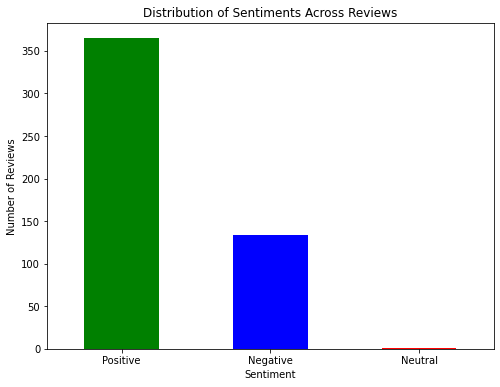

Positive    365
Negative    134
Neutral       1
Name: sentiment, dtype: int64

In [12]:
import matplotlib.pyplot as plt

# Insight 1: Distribution of sentiments across all reviews
sentiment_counts = analysis_df['sentiment'].value_counts()

# Plotting the sentiment distribution
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['green', 'blue', 'red'])
plt.title('Distribution of Sentiments Across Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.show()

sentiment_counts


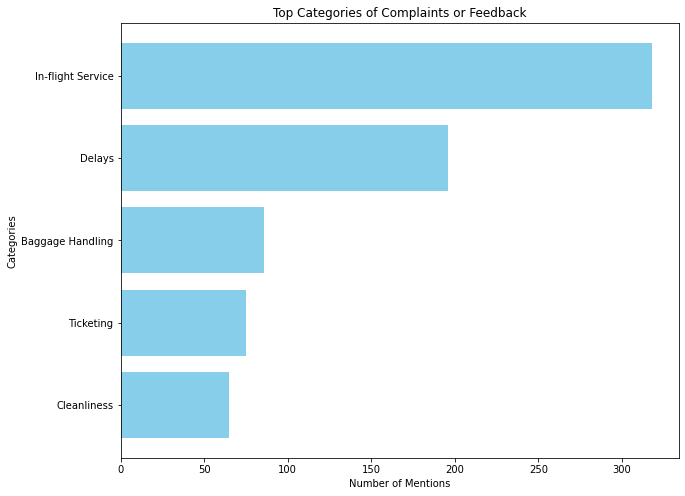

,Category,Count
0,In-flight Service,318
2,Delays,196
1,Baggage Handling,86
4,Ticketing,75
3,Cleanliness,65


In [13]:
from collections import Counter

# Insight 2: Top categories of complaints or feedback
# Flatten the list of categories from all reviews and count occurrences
all_categories = [category for sublist in analysis_df['categories'] for category in sublist]
category_counts = Counter(all_categories)

# Convert to a DataFrame for better visualization
category_counts_df = pd.DataFrame(category_counts.items(), 
                                  columns=['Category', 'Count']).sort_values(by='Count', 
                                                                             ascending=False)

# Plotting the top categories
plt.figure(figsize=(10, 8))
plt.barh(category_counts_df['Category'], category_counts_df['Count'], color='skyblue')
plt.title('Top Categories of Complaints or Feedback')
plt.xlabel('Number of Mentions')
plt.ylabel('Categories')
plt.gca().invert_yaxis()  # To display the highest count at the top
plt.show()

category_counts_df


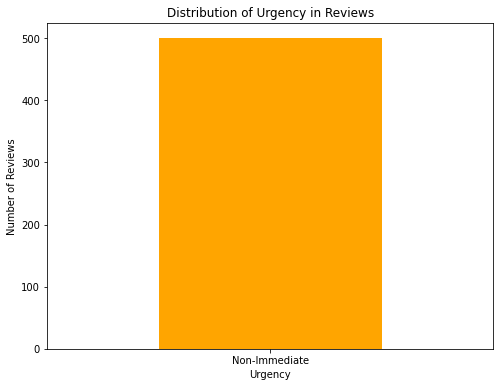

Non-Immediate    500
Name: urgency, dtype: int64

In [14]:
# Insight 3: Number of reviews indicating immediate urgency
urgency_counts = analysis_df['urgency'].value_counts()

# Plotting the urgency count
plt.figure(figsize=(8, 6))
urgency_counts.plot(kind='bar', color=['orange', 'grey'])
plt.title('Distribution of Urgency in Reviews')
plt.xlabel('Urgency')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.show()

urgency_counts


In [15]:
# Insight 4: Mention of risks in the reviews
# Since risks are in a list format in each row, we'll check if any row contains non-empty lists
risks_present = analysis_df['risks'].apply(lambda risks: len(risks) > 0)

# Count how many reviews have mentioned risks
number_of_risks = risks_present.sum()

# Output the number of reviews mentioning risks
number_of_risks


11

In [16]:
# Insight 5: Common themes or specific phrases in the 'additional_info' column

# First, we'll see how many reviews contain additional information
additional_info_present = analysis_df['additional_info'].apply(lambda info: len(info.strip()) > 0)

# Count how many reviews have additional information
number_of_additional_info = additional_info_present.sum()

# Show some examples of the additional information provided, if available
additional_info_examples = analysis_df[analysis_df['additional_info'] != '']['additional_info'].head(10).tolist()

number_of_additional_info, additional_info_examples


(116,
 ["Compared to the likes of EVA Air or Qatar Airways, British Airways Club World is by far the poor relation. Flew from Glasgow to New York via LHR, the seats have zero storage apart from the small drawer at floor level. It is astonishing that for the money they charge, you have to step over the legs of the person on your outside, especially if you accidentally trip and land on top of them. Food was satisfactory although a small bacon roll for breakfast was again a poor show. AVOD was also satisfactory. Apart from the flat bed, this just really doesn't have a premium feel about it. On our recent trip, on both legs, the crew were excellent, but the product from our national flag carrier simply is not worth the premium prices they charge.",
  'LHR-Washington on a 777-200. Trip got off to a good start in the BA Concorde 1st Class lounge. Nice champagne and a nice quiet ambiance which I like. The place is starting to show signs of wear and tear - with sagging seat cushions. Plane was